<CENTER>
</br>
<p><font size="6">  Go Board Detection </font></p>

</p>
</CENTER>


In this notebook, we're going to explain step by step how to detect a go board and represent it visually given a frame from a Go game recording.

We're going to use a custom trained Yolov8 model (see "Transfer learning YoloV8.ipynb") to detect stones, corners and empty intersections. We're then going to use the empty intersections to find the rest of the intersections by interpolating and finding the missing lines. We then create a map for the board and assign each stone to its position. 

All of the steps needs to take into account many (explain that its hard when it comes to a video etc etc)

> 1. 

In [4]:
#imports
from mySgf import GoBoard, GoSgf
import numpy as np
from processing import *
from ultralytics import YOLO
import copy
import matplotlib.pyplot as plt

We start by loading our custom trained model and fetch results

In [3]:
frame = cv2.imread(f"img3.jpg")

model = YOLO('model.pt')

results = model(frame)
annotated_frame = results[0].plot(labels=False, conf=False)



0: 480x800 12 black_stones, 1 board, 4 board_corners, 85 emptys, 22 empty_edges, 10 white_stones, 228.9ms
Speed: 7.3ms preprocess, 228.9ms inference, 10.7ms postprocess per image at shape (1, 3, 480, 800)


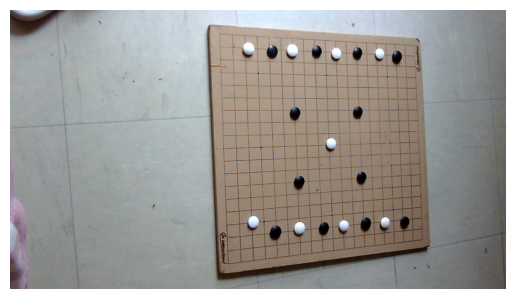

In [9]:
frame_ = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
annotated_frame_ = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)

plt.imshow(frame_)
plt.axis('off')  
plt.show()

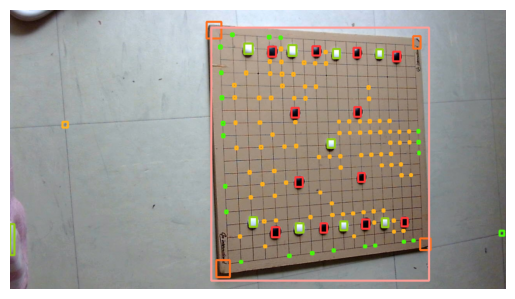

In [10]:
plt.imshow(annotated_frame_)
plt.axis('off')  
plt.show()

We fetch the corners, making sure we only take 4 of them by eliminating unecessary or false detections. We do that by first applying a non-max-suppression to calculate the best box out of a set of overlapping bounding boxes (on the same corner) based on their confidence levels.

Next, we eliminate corners that were fasly detected outside of the board.

Finally, we calculate the centers of the bounding boxes and sort them.

In [ ]:
def non_max_suppression(boxes, overlapThresh=0.5):
    """
    Apply non-maximum suppression to eliminate redundant bounding boxes.

    Args:
    -----------
    boxes : numpy.ndarray
            Array of bounding boxes with coordinates [x1, y1, x2, y2].
    overlapThresh : float, optional
                    Threshold for overlap to consider bounding boxes as redundant (default=0.5).

    Returns:
    --------
    numpy.ndarray
        Array of picked bounding boxes after non-maximum suppression.
    """
    
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes	
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

In [11]:
def are_corner_inside_box(corner_boxes, board_box):
    
    x1, y1, x2, y2 = board_box

    # Extract the coordinates of the squares
    square_x1 = corner_boxes[:, 0]
    square_y1 = corner_boxes[:, 1]
    square_x2 = corner_boxes[:, 2]
    square_y2 = corner_boxes[:, 3]

    # Check if any corner of the corner_boxes is inside the board_box
    condition = (
        ((square_x1 >= x1) & (square_x1 <= x2) & (square_y1 >= y1) & (square_y1 <= y2)) |
        ((square_x2 >= x1) & (square_x2 <= x2) & (square_y1 >= y1) & (square_y1 <= y2)) |
        ((square_x1 >= x1) & (square_x1 <= x2) & (square_y2 >= y1) & (square_y2 <= y2)) |
        ((square_x2 >= x1) & (square_x2 <= x2) & (square_y2 >= y1) & (square_y2 <= y2))
    )

    # Select corner_boxes that meet the condition
    return corner_boxes[condition]

In [12]:
def get_corners(results):    
    corner_boxes = np.array(results[0].boxes.xyxy[results[0].boxes.cls == 2])

    corner_boxes = non_max_suppression(corner_boxes)
    
    board_model_edges = results[0].boxes.xyxy[results[0].boxes.cls == 1][0]
    
    corner_boxes = are_corner_inside_box(corner_boxes, np.array(board_model_edges))

    if len(corner_boxes) != 4:
        raise Exception(f">>>>Incorrect number of corners! Detected {len(corner_boxes)} corners")

    corner_centers = ((corner_boxes[:,[0, 1]] + corner_boxes[:,[2, 3]])/2)
    # corner_centers = corner_centers
    
    corner_centers = corner_centers[corner_centers[:, 1].argsort()]
    
    upper = corner_centers[:2]
    lower = corner_centers[2:]
    
    upper = upper[upper[:, 0].argsort()]
    lower = lower[lower[:, 0].argsort()[::-1]]
    
    return np.concatenate((upper, lower)).astype(dtype=np.float32)

In [13]:
input_points = get_corners(results)

Given the corners' positions, we can now calculate the perspective matrix and get the transformed image. 

In [14]:
output_edge = 600
output_points = np.array([[0, 0], [output_edge, 0], [output_edge, output_edge], [0, output_edge]], dtype=np.float32)

perspective_matrix = cv2.getPerspectiveTransform(input_points, output_points)
transformed_image = cv2.warpPerspective(frame, perspective_matrix, (output_edge, output_edge))

Next, we're going to find the lines making up the board grid.
We start by fetching all the possible points that could help us identify lines, like empty intersections, empty edges and empty corners, and apply perspective transform. We then apply Kmeans algorithm to classify coordinates and group points who form one line; first we apply clustering on x-coordinates to find vertical lines, then on y-coordinates to find horizontal ones.

This automatically classifies lines into vertical and horizontal.

Next, we interpolate the lines to get complete lines having endpoints in the edges of the image, so that we can later calculate all intersections.

In [15]:
def adress_lines(lines):
    """
    Sort the order of endpoints

    Args:
    -----------
    lines: list
        list of lines unsorted
    
    Returns:
    --------
    list
        sorted lines    
    """
    for i in range(len(lines)):
        x1, y1, x2, y2 = lines[i]
        if (x1 + y1) > (x2 + y2):
            x1, x2, y1, y2 = x2, x1, y2, y1
            lines[i] = x1, y1, x2, y2
    return lines

In [16]:
def lines_detection(model_results, perspective_matrix):
    """
    Process model results to identify and cluster all intersections.

    Args:
    -----------
    model_results : numpy.ndarray
                    List of model results containing information about boxes.
    perspective_matrix : numpy.ndarray
                    Perspective transformation matrix
    
    Returns:
    --------
    Tuple of two numpy.ndarrays representing clustered vertical and horizontal lines.
    """

    empty_intersections = model_results[0].boxes.xywh[model_results[0].boxes.cls == 3][:,[0, 1]]
    empty_corner = model_results[0].boxes.xywh[model_results[0].boxes.cls == 4][:,[0, 1]]
    empty_edge = model_results[0].boxes.xywh[model_results[0].boxes.cls == 5][:,[0, 1]]


    if not empty_intersections is None:
        if len(empty_intersections) != 0:
            empty_intersections = np.array(empty_intersections[:, [0, 1]])
            empty_intersections = cv2.perspectiveTransform(empty_intersections.reshape((1, -1, 2)), perspective_matrix).reshape((-1, 2))

    if not empty_corner is None:
        if len(empty_corner) != 0:
            empty_corner = np.array(empty_corner[:, [0, 1]])
            empty_corner = cv2.perspectiveTransform(empty_corner.reshape((1, -1, 2)), perspective_matrix).reshape((-1, 2))

    if not empty_edge is None:
        if len(empty_edge) != 0:
            empty_edge = np.array(empty_edge[:, [0, 1]])
            empty_edge = cv2.perspectiveTransform(empty_edge.reshape((1, -1, 2)), perspective_matrix).reshape((-1, 2))

    all_intersections = np.concatenate((empty_intersections, empty_corner, empty_edge), axis=0)

    all_intersections = all_intersections[(all_intersections[:, 0:2] >= 0).all(axis=1) & (all_intersections[:, 0:2] <= 600).all(axis=1)]

    all_intersections = all_intersections[all_intersections[:, 0].argsort()]

    all_intersections_x = all_intersections[:,0].reshape((-1, 1))

    kmeans = KMeans(n_clusters=19, n_init=10)
    kmeans.fit(all_intersections_x)

    # Get the cluster labels for each line
    cluster_labels = kmeans.labels_
    unique_labels, label_counts = np.unique(cluster_labels, return_counts=True)

    # Sort the labels based on their counts in decreasing order
    sorted_indices = np.argsort(label_counts)[::-1]
    sorted_unique_labels = unique_labels[sorted_indices]


    lines_equations = np.array([]).reshape((-1, 2))
    lines_points_length = np.array([])
    cluster_vertical = np.array([]).reshape((-1, 4))

    for i, label in enumerate(sorted_unique_labels):
        line = all_intersections[cluster_labels==label]
        # print(i, len(line), line)
        # draw_points(line.astype(int), img)
        if len(line) > 2:
            # line = line[np.argsort(line[:, 1])]
            slope, intercept = np.polyfit(line[:,1], line[:,0], 1) # on inverse x et y
            line_ = np.array([intercept, 0, slope * 600 + intercept, 600])# on iverse les x et y
            lines_equations = np.append(lines_equations, [[slope, intercept]], axis=0)
        else:
            if len(cluster_vertical) == 0:
                raise Exception(f">>>>>> Cannot reconstruct ALL VERTICAL LINES")
            elif len(line) < 1:
                raise Exception(f">>>>>> Cannot reconstruct vertical line at point {line}")
            else:
                x1, y1 = line[0]
                slope = np.average(lines_equations[:,0], weights=lines_points_length, axis=0)
                intercept = x1 - slope * y1
                line_ = np.array([intercept, 0, slope * 600 + intercept, 600])
                lines_equations = np.append(lines_equations, [[slope, intercept]], axis=0)
        lines_points_length = np.append(lines_points_length, [len(line)], axis=0)
        
        # x1, y1, x2, y2 = line_.astype(np.uint32)
        # cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 1)
        # draw_points([(x1, y1), (x2, y2)], img)
        
        cluster_vertical = np.append(cluster_vertical, [line_], axis=0)
    cluster_vertical = adress_lines(cluster_vertical)
    cluster_vertical = np.sort(cluster_vertical, axis=0).astype(int)


    all_intersections = all_intersections[all_intersections[:, 1].argsort()]
    all_intersections_y = all_intersections[:,1].reshape((-1, 1))

    kmeans = KMeans(n_clusters=19, n_init=10)
    kmeans.fit(all_intersections_y)

    # Get the cluster labels for each line
    cluster_labels = kmeans.labels_
    unique_labels, label_counts = np.unique(cluster_labels, return_counts=True)

    # Sort the labels based on their counts in decreasing order
    sorted_indices = np.argsort(label_counts)[::-1]
    sorted_unique_labels = unique_labels[sorted_indices]

    # img = np.copy(transformed_image)
    lines_equations = np.array([]).reshape((-1, 2))
    lines_points_length = np.array([])
    cluster_horizontal = np.array([]).reshape((-1, 4))

    for label in sorted_unique_labels:
        line = all_intersections[cluster_labels==label]
        
        if len(line) > 2:
            line = line[np.argsort(line[:, 0])]
            slope, intercept = np.polyfit(line[:,0], line[:,1], 1)
            line = np.array([0, intercept, 600, slope * 600 + intercept])
            lines_equations = np.append(lines_equations, [[slope, intercept]], axis=0)
        else:
            if len(cluster_horizontal) == 0:
                raise Exception(f">>>>>> Cannot reconstruct ALL HORIZONTAL LINES")
            elif len(line) < 1:
                raise Exception(f">>>>>> Cannot reconstruct line at point {line}")
            else:
                x1, y1 = line[0]
                slope = np.average(lines_equations[:,0], weights=lines_points_length, axis=0)
                intercept = y1 - slope * x1
                line = np.array([0, intercept, 600, slope * 600 + intercept])
                lines_equations = np.append(lines_equations, [[slope, intercept]], axis=0)
        lines_points_length = np.append(lines_points_length, [len(line)], axis=0)
        
        # x1, y1, x2, y2 = line.astype(int)
        # cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 1)
        # draw_points([(x1, y1), (x2, y2)], img)
        cluster_horizontal = np.append(cluster_horizontal, [line], axis=0)
    cluster_horizontal = adress_lines(cluster_horizontal)
    cluster_horizontal = np.sort(cluster_horizontal, axis=0).astype(int)
 
    return np.array(cluster_vertical).reshape((-1, 4)), np.array(cluster_horizontal).reshape((-1, 4))

In [17]:
vertical_lines, horizontal_lines = lines_detection(results, perspective_matrix)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Next, we have to clean the lines we interpolated to eliminate any duplicates.

In [21]:
def are_similar(line1, line2, threshold=10):
    """
    Compare two lines and decide if they're almost the same line based on a certain threshold

    Args:
    -----------
    line1: numpy.ndarray
        4 elements array representing the first line [x1, y1, x2, y2]
    line2: numpy.ndarray
        4 elements array representing the second line [x1, y1, x2, y2]
    threshold: int
        Smallest the difference between 2 lines (default is 10)
    
    Returns:
    --------
    bool
        true if similar, else false    
    """
    return np.all(np.abs(line1 - line2) <= threshold)

In [22]:
def removeDuplicates(lines):
    """
    Group similar lines and take the average of each group to keep one line per group

    Args:
    -----------
    lines: list
        list of lines to be filtered
    
    Returns:
    --------
    numpy.ndarray
        filtered list of lines   
    """
    grouped_lines = {}
    for line in lines:
        x1, y1, x2, y2 = line
        found = False
        for key in grouped_lines.keys():
            for element in grouped_lines[key]:
                if are_similar(element, line, threshold=15):
                    grouped_lines[key] = grouped_lines[key] + [line]
                    found = True
                    break
        if not found:
            grouped_lines[(x1, y1, x2, y2)] = [line]

    final_lines2 = []
    second_dict = {}
    for key in grouped_lines.keys():
        mean_line = np.mean(grouped_lines[key], axis=0).astype(dtype=int)
        final_lines2.append(mean_line)
        second_dict[tuple(mean_line)] = [mean_line]
    
    for line in lines:
        x1, y1, x2, y2 = line
        found = False
        for key in second_dict.keys():
            if are_similar(key, line, threshold=5):
                second_dict[key] = second_dict[key] + [line]
                found = True
                break
            
    final_lines = []
    for key in second_dict.keys():
        mean_line = np.mean(second_dict[key], axis=0).astype(dtype=int)
        final_lines.append(mean_line)
    
    return np.array(final_lines).astype(np.int32)

In [23]:
vertical_lines = removeDuplicates(vertical_lines)
horizontal_lines = removeDuplicates(horizontal_lines)

Since not all the intersections will be detected, there will always be some missing lines on the grid. So we find the common distance between the lines so that we can add the missing lines in between lines with the correct spacing.

In [27]:
def calculate_distances(lines):
    """
    Calculate distances between consecutive lines.

    Args:
    -----------
    lines : numpy.ndarray
            Array of lines represented by coordinates [x1, y1, x2, y2].

    Returns:
    --------
    list : numpy.ndarray
            List of distances between consecutive lines.
    """
    distances = [(np.linalg.norm(lines[i + 1][:2]-lines[i][:2]) + np.linalg.norm(lines[i + 1][2:]-lines[i][2:])) / 2 for i in range(len(lines) - 1)]
    return distances

In [24]:
def find_common_distance(distances, target_distance=30):
    """
    Find the common distance among a set of distances using DBSCAN clustering.

    Args:
    -----------
    distances : list
                List of distances to be clustered and analyzed.
    target_distance : float, optional
                      The target distance to find among the clusters (default=30).

    Returns:
    --------
    Tuple
        Tuple containing the mean of the distances in the cluster with the target distance
        and the distances in that cluster.
    """
    
    # Reshape distances into a column vector
    distances_ = np.array(distances).reshape((-1, 1))

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=1, min_samples=1)
    labels = dbscan.fit_predict(distances_)
    
    means = np.array([])
    unique_labels = np.unique(labels)
    label_index = np.array([])
    
    # Calculate means for each cluster and store label and mean in arrays
    for label in unique_labels:
        means = np.append(means, np.mean(distances_[labels==label]))
        label_index = np.append(label_index, label)

    # Find the index of the cluster with the closest mean to the target distance
    index = np.argmin(np.abs(means - target_distance))
    
    # Return the mean of distances in the chosen cluster and the distances in that cluster
    return means[index], distances_[labels==label_index[index]]


In [25]:

def is_approx_multiple(value, base, threshold):
    """
    Check if a value is approximately a multiple of a given base within a specified threshold.

    Args:
    -----------
    value : float
            The value to check.
    base : float
           The base value for which the check is performed.
    threshold : float
                The maximum allowed deviation from being a multiple.

    Returns:
    --------
    bool
        True if the value is approximately a multiple of the base within the threshold, False otherwise.
    """
    return abs(value - math.floor(value / base) * base) < threshold

In [28]:
def restore_missing_lines(lines, distance_threshold=10):
    """
    Restore missing lines in a set of lines based on a common distance.

    Args:
    -----------
    lines : numpy.ndarray of shape (-1, 4)
            Array of lines represented by coordinates [x1, y1, x2, y2].
    distance_threshold : int, optional
                        Maximum threshold for spacing deviation to consider missing lines (default=10).

    Returns:
    --------
    numpy.ndarray
        Array of lines with restored missing lines.
    """
    # ax=0 : x axis / ax=1 : y axis
    lines = np.sort(lines, axis=0)
    distances = calculate_distances(lines)
    
    # If there are less than or equal to 1 distance, no restoration needed
    if len(distances) <= 1:
        return lines
    
    # Find mean distance and distances array after removing outliers
    mean_distance, distances = find_common_distance(distances)
    restored_lines = []
    
    for i in range(len(lines) - 1):
        spacing = (np.linalg.norm(lines[i + 1][:2]-lines[i][:2]) + np.linalg.norm(lines[i + 1][2:]-lines[i][2:]))/2
        
        if is_approx_multiple(spacing, mean_distance, distance_threshold):
            num_missing_lines = round(spacing / mean_distance) - 1
            
            for j in range(1, num_missing_lines + 1):
                if is_vertical(*lines[i]):
                    x1 = lines[i][0] + j * mean_distance
                    y1 = lines[i][1]
                    x2 = lines[i][2] + j * mean_distance
                    y2 = lines[i][3]
                else:
                    x1 = lines[i][0]
                    y1 = lines[i][1] + j * mean_distance
                    x2 = lines[i][2]
                    y2 = lines[i][3] + j * mean_distance
                restored_lines.append([x1, y1, x2, y2])
    
    # Append the restored lines to the original lines array
    if len(restored_lines) != 0:
        lines = np.append(lines, np.array(restored_lines, dtype=int), axis=0)
    
    # Sort the lines array
    lines = np.sort(lines, axis=0)
    
    return lines

In [29]:
vertical_lines = restore_missing_lines(vertical_lines)
horizontal_lines = restore_missing_lines(horizontal_lines)

The previous algorithme doesn't restore lines in the edges, so we define a separate function to do that.

In [30]:
def average_distance(lines):
    distances = [line_distance(lines[i + 1], lines[i]) for i in range(len(lines) - 1)]
    mean_distance = np.average(distances)
    return mean_distance

In [31]:
def add_lines_in_the_edges(lines, type):
    mean_distance = average_distance(lines)

    if len(lines) != 18:
        return lines
    
    if type == "vertical":
        # 600 being the image size
        left_border =  np.array([0, 0, 0, 600])
        right_border = np.array([600, 0, 600, 600])
        if line_distance(lines[0], left_border) > mean_distance:
            x1 = lines[0][0]-mean_distance
            y1 = lines[0][1]
            x2 = lines[0][2]-mean_distance
            y2 = lines[0][3]
            lines = np.append(lines, [[x1, y1, x2, y2]], axis=0)
        elif line_distance(lines[-1], right_border) > mean_distance:
            x1 = lines[-1][0]+mean_distance
            y1 = lines[-1][1]
            x2 = lines[-1][2]+mean_distance
            y2 = lines[-1][3]  
            print([[x1, y1, x2, y2]])  
            lines = np.append(lines, [[x1, y1, x2, y2]], axis=0)
        else:
            print("No missing edges in the vertical lines")


    elif type == "horizontal":
        # 600 being the image size
        top_border =  np.array([0, 0, 600, 0])
        bottom_border = np.array([0, 600, 600, 600])
        if line_distance(lines[0], top_border) > mean_distance:
            x1 = lines[0][0]
            y1 = lines[0][1]-mean_distance
            x2 = lines[0][2]
            y2 = lines[0][3]-mean_distance
            lines = np.append(lines, [[x1, y1, x2, y2]], axis=0)
        elif line_distance(lines[-1], bottom_border) > mean_distance:
            x1 = lines[-1][0]
            y1 = lines[-1][1]+mean_distance
            x2 = lines[-1][2]
            y2 = lines[-1][3]+mean_distance   
            lines = np.append(lines, [[x1, y1, x2, y2]], axis=0)
 
        else:
            print("No missing edges in the horizontal lines")
                
    else:
        print("Please specify a line type")
    
    return lines.astype(int)